In [1]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/landlord/handwriting-recognition")

Skipping, found downloaded files in "./handwriting-recognition" (use force=True to force download)


In [ ]:
import opendatasets as od

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import random
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# import os
# for dirname, _, filenames in os.walk('./handwriting-recognition/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
train_df = pd.read_csv('./handwriting-recognition/written_name_train_v2.csv')
train_df

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE
...,...,...
330956,TRAIN_330957.jpg,LENNY
330957,TRAIN_330958.jpg,TIFFANY
330958,TRAIN_330959.jpg,COUTINHO DESA
330959,TRAIN_330960.jpg,MOURAD


In [4]:
print("There are total",len(train_df['IDENTITY'].unique()),"unique  signatures.")
train_df['IDENTITY'].value_counts()

There are total 100540 unique  signatures.


IDENTITY
THOMAS           1825
EMPTY            1796
LEA              1582
EMMA             1482
LUCAS            1479
                 ... 
DE METZ             1
SCHOPPMANN          1
SCHNITZLER          1
HELYIL              1
COUTINHO DESA       1
Name: count, Length: 100539, dtype: int64

In [78]:
# j = 5
# for i,img_path in enumerate(train_df[train_df['IDENTITY']=="THOMAS"]["FILENAME"]):
#     image = io.imread('./handwriting-recognition/train_v2/train/'+img_path)
#     io.imshow(image)
#     io.show()
#     print(img_path)
#     if i > j:
#         break

In [5]:
train_df.isna().sum()

FILENAME      0
IDENTITY    565
dtype: int64

In [6]:
train_df.dropna(inplace=True)
train_df.reset_index(drop=True, inplace=True)
train_df

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE
...,...,...
330391,TRAIN_330957.jpg,LENNY
330392,TRAIN_330958.jpg,TIFFANY
330393,TRAIN_330959.jpg,COUTINHO DESA
330394,TRAIN_330960.jpg,MOURAD


In [7]:
test_df = pd.read_csv('./handwriting-recognition/written_name_test_v2.csv')
test_df.head(5)

,FILENAME,IDENTITY
0,TEST_0001.jpg,KEVIN
1,TEST_0002.jpg,CLOTAIRE
2,TEST_0003.jpg,LENA
3,TEST_0004.jpg,JULES
4,TEST_0005.jpg,CHERPIN


In [8]:
test_df['IDENTITY'].value_counts()

IDENTITY
THOMAS        227
EMPTY         221
EMMA          202
LEA           200
HUGO          187
             ... 
KIFANI          1
AOUINI          1
VINCENS         1
DE MIRANDA      1
MELAB           1
Name: count, Length: 20279, dtype: int64

In [9]:
test_df.isna().sum()

FILENAME     0
IDENTITY    70
dtype: int64

In [10]:
test_df.dropna(inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_df

,FILENAME,IDENTITY
0,TEST_0001.jpg,KEVIN
1,TEST_0002.jpg,CLOTAIRE
2,TEST_0003.jpg,LENA
3,TEST_0004.jpg,JULES
4,TEST_0005.jpg,CHERPIN
...,...,...
41295,TEST_41366.jpg,ALEXANE
41296,TEST_41367.jpg,PEREIRA-SILVA
41297,TEST_41368.jpg,LAURENT
41298,TEST_41369.jpg,DEFFENSE


In [11]:
val_df = pd.read_csv('./handwriting-recognition/written_name_validation_v2.csv')
val_df.head(5)

,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER
2,VALIDATION_0003.jpg,LEA
3,VALIDATION_0004.jpg,JEAN-ROCH
4,VALIDATION_0005.jpg,RUPP


In [12]:
val_df['IDENTITY'].value_counts()

IDENTITY
THOMAS     219
LEA        204
LUCAS      195
EMPTY      187
EMMA       186
          ... 
ROIGNA       1
VULLIEZ      1
OUAZAN       1
BUFF         1
MARWANE      1
Name: count, Length: 20227, dtype: int64

In [13]:
val_df.isna().sum()

FILENAME     0
IDENTITY    78
dtype: int64

In [14]:
val_df.dropna(inplace=True)
val_df.reset_index(drop=True, inplace=True)
val_df

,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER
2,VALIDATION_0003.jpg,LEA
3,VALIDATION_0004.jpg,JEAN-ROCH
4,VALIDATION_0005.jpg,RUPP
...,...,...
41287,VALIDATION_41366.jpg,CHAILLAN
41288,VALIDATION_41367.jpg,BAROUH
41289,VALIDATION_41368.jpg,MAXENCE
41290,VALIDATION_41369.jpg,HAMELIN


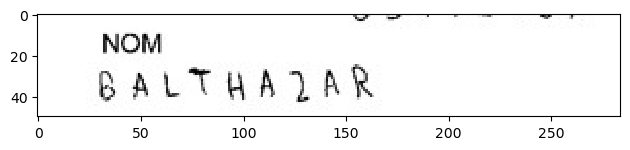

In [15]:
from skimage import io
image = io.imread('./handwriting-recognition/train_v2/train/TRAIN_00001.jpg')
io.imshow(image)
io.show()

In [16]:
image.shape

(50, 284, 3)

In [17]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import string
from PIL import Image

In [85]:
class CustomDataset(Dataset):
    def __init__(self,image_path, dataframe,transform=None, target_transform=None):
        self.df = dataframe
        self.image_path = image_path
        self.transform =transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        image_filepath = os.path.join(self.image_path+self.df['FILENAME'][idx])
        image = Image.open(image_filepath).convert('L')  # Convert to grayscale
        vocab = string.ascii_letters + string.digits + string.punctuation + " "
        char_to_idx = {char: idx for idx, char in enumerate(vocab)}  # char -> index
        idx_to_char = {idx: char for idx, char in enumerate(vocab)}  # index -> char
        max_len = train_df['IDENTITY'].str.len().max()
        label = self.df['IDENTITY'][idx]
        # print(type(label))
        char_to_idx['<PAD>'] = 0
        # print(char_to_idx)
        label_indices = [char_to_idx[str(char)] for char in label]  # Convert to indices
        padded_label = label_indices + [int(char_to_idx['<PAD>'])] * (int(max_len - len(label_indices)))
        if self.transform:
            image = self.transform(image)
        label_tensor = torch.tensor(padded_label,dtype=torch.long).unsqueeze(-1)
        return image,label_tensor,label

In [87]:
batch_size = 396

In [89]:
transform = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
train_image_path = './handwriting-recognition/train_v2/train/'
train_dataset = CustomDataset(train_image_path,train_df,transform=transform)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

test_image_path = './handwriting-recognition/test_v2/test/'
test_dataset = CustomDataset(test_image_path,test_df,transform=transform)
test_loader = DataLoader(test_dataset,batch_size=batch_size)

val_image_path = './handwriting-recognition/validation_v2/validation/'
val_dataset = CustomDataset(val_image_path,val_df,transform=transform)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)

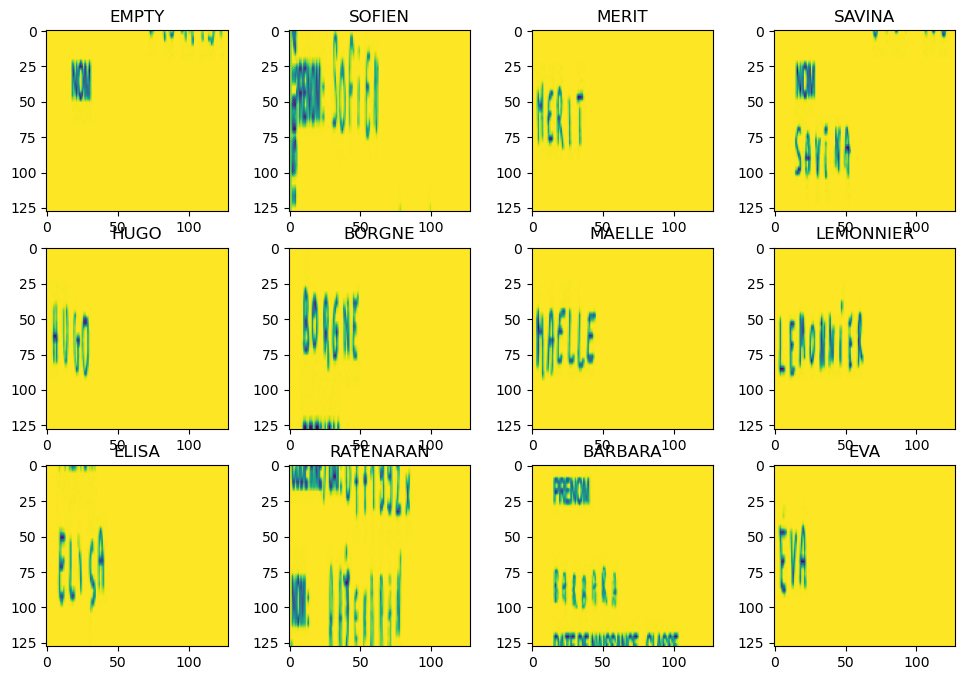

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F

num_images = 12
images, label_tensor,label = next(iter(train_loader))
random_images = random.sample(range(len(images)),num_images)
plt.figure(figsize=(12, 8))
rows, cols = 3, 4
for i,img in enumerate(random_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[img].squeeze(0).numpy())
    plt.title(label[img])

In [95]:
if not torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = "cpu"

In [92]:
# Generator Network (Conditional GAN Generator)
class HandwritingGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, lstm_hidden_dim, noise_dim, image_size):
        super(HandwritingGenerator, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, lstm_hidden_dim, batch_first=True)
        self.text_fc = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        
        self.fc1 = nn.Linear(lstm_hidden_dim + noise_dim, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, image_size * image_size)
    
    def forward(self, text_input, noise):
        text_input = text_input.squeeze(-1)
        embedded_text = self.embedding(text_input)
    
        _, (hidden, _) = self.lstm(embedded_text)
        text_features = self.text_fc(hidden.squeeze(0))
        
        combined_input = torch.cat([text_features, noise], dim=1)
        x = F.relu(self.fc1(combined_input))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x.view(x.size(0), 1, 128, 128)


class HandwritingDiscriminator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, image_size):
        super(HandwritingDiscriminator, self).__init__()
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)  
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1) 
        
        self.text_fc = nn.Linear(embedding_dim, 512)
        self.image_fc = nn.Linear(512 * (image_size // 16) * (image_size // 16), 512)
        self.final_fc = nn.Linear(1024, 1)

    def forward(self, image, text_input):
        text_input = text_input.squeeze(-1)
        embedded_text = self.embedding(text_input)
        text_features = torch.mean(embedded_text, dim=1)
        text_features = F.relu(self.text_fc(text_features))

        x = F.leaky_relu(self.conv1(image), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        x = x.view(x.size(0), -1)
        image_features = F.relu(self.image_fc(x))
        # Step 3: Combine image and text features
        combined_features = torch.cat([image_features, text_features], dim=1)
        
        # Step 4: Classification
        validity = torch.sigmoid(self.final_fc(combined_features))
        return validity

vocab_size = 20227
embedding_dim = 128
noise_dim=100
noise = torch.randn(batch_size, noise_dim).to(device)
generator = HandwritingGenerator(vocab_size,embedding_dim,lstm_hidden_dim=256,noise_dim=noise_dim,image_size=128).to(device)
discriminator = HandwritingDiscriminator(vocab_size,embedding_dim,128).to(device)

In [97]:
# Optimizers specified in the torch.optim package

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002,betas=(0.5, 0.999))
criterion = nn.BCELoss()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [99]:
EPOCHS = 10
disc_losses = []
gen_losses = []
best_gen_loss = float('inf')

for epoch in range(EPOCHS):
    for i,data in enumerate(train_loader):
        # print(images.shape,'0')
        images,label_tensor,label = data
        images = images.to(device)

        #Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train discriminator with real images
        discriminator_optimizer.zero_grad()
        real_output = discriminator(images,label_tensor)
        real_loss = criterion(real_output, real_labels)
        
        #Train discriminator with fake image
        fake_image = generator(label_tensor,noise).detach()
        fake_output = discriminator(fake_image,label_tensor)
        fake_loss = criterion(fake_output, fake_labels)

        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        discriminator_optimizer.step()

        #Train Generator
        generator_optimizer.zero_grad()
        fake_labels = torch.ones(batch_size, 1)
        fake_outputs = discriminator(fake_image,label_tensor)
        gen_loss = criterion(fake_outputs, real_labels)
        gen_loss.backward()
        generator_optimizer.step()
        disc_losses.append(disc_loss)
        gen_losses.append(gen_loss)
    if gen_loss.item() < best_gen_loss:
        best_gen_loss = gen_loss.item()
        torch.save(generator.state_dict(), "best_generator.pth")  # Save best generator model
        print(f"New best generator model saved with loss: {best_gen_loss:.4f}")
        
    print(f"Epoch [{epoch+1}/{EPOCHS}], Disc Loss: {disc_loss.item():.4f}, Gen Loss: {gen_loss.item():.4f}")

KeyboardInterrupt: 

In [101]:
!pip install expand-abbreviation

ERROR: Could not find a version that satisfies the requirement expand-abbreviation (from versions: none)
ERROR: No matching distribution found for expand-abbreviation

[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
